In [1]:
%matplotlib inline 
# %matplotlib notebook # for interactive

For high dpi displays.

In [2]:
%config InlineBackend.figure_format = 'retina'

# 0. Note

- This notebook shows an example of how to conduct equation of state fitting for the pressure-volume-temperature data using `pytheos`.

- Advantage of using `pytheos` is that you can apply different pressure scales and different equations without much coding.  

- We use data on SiC from [Nisr et al. (2017, JGR-Planet)]().

# 1. Setup

In [3]:
import numpy as np
import uncertainties as uct
import pandas as pd
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt
import pytheos as eos

# 2. Setups for fitting with two different gold pressure scales

Equations of state of gold from Fei et al. (2007, PNAS) and Dorogokupets and Dewaele (2007, HPR).  These equations are provided from `pytheos` as built-in classes.

In [4]:
au_eos = {'Fei2007': eos.gold.Fei2007bm3(), 'Dorogokupets2007': eos.gold.Dorogokupets2007()}

Because we use Birch-Murnaghan eos version of Fei2007 and Dorogokupets2007 used Vinet eos, we create a dictionary to provide different static compression eos for the different pressure scales used.

In [5]:
st_model = {'Fei2007': eos.BM3Model, 'Dorogokupets2007': eos.VinetModel}

In [6]:
k0 = {'Fei2007': 241.2, 'Dorogokupets2007': 243.0}
k0p = {'Fei2007': 2.84, 'Dorogokupets2007': 2.68}

Initial guess:

In [7]:
gamma0 = 1.06
q = 1.
theta0 = 1200.

Physical constants for different materials

In [8]:
v0 = 82.8042
n = 2.
z = 4.

# 3. Setup data (3C)

Data file is in `csv` format.

In [9]:
data = pd.read_csv('./data/3C-HiTEOS-final.csv')

In [10]:
data.head()

,V(Au),sV(Au),V(3C),sV(3C),T(3C),sT(3C)
0,59.481877,0.080243,73.1264,0.0366,1725.0,42.426407
1,59.425646,0.053745,73.0702,0.0443,1703.0,43.133514
2,59.434845,0.026847,73.0259,0.0442,1846.0,47.376154
3,59.405714,0.050305,72.9729,0.0365,1821.0,43.840620
4,59.399059,0.046041,72.9829,0.0365,1862.0,41.012193


In [11]:
data.columns

Index(['V(Au)', 'sV(Au)', 'V(3C)', 'sV(3C)', 'T(3C)', 'sT(3C)'], dtype='object')

In [12]:
v_std = unp.uarray( data['V(Au)'], data['sV(Au)'])
temp = unp.uarray(data['T(3C)'], data['sT(3C)'])
v = unp.uarray(data['V(3C)'], data['sV(3C)'])

`pytheos` provides `plot.thermal_data` function to show the data distribution in the P-V and P-T spaces.

In [13]:
key = 'Dorogokupets2007' ##  'Fei2007' #

Calculate pressure and plot the data

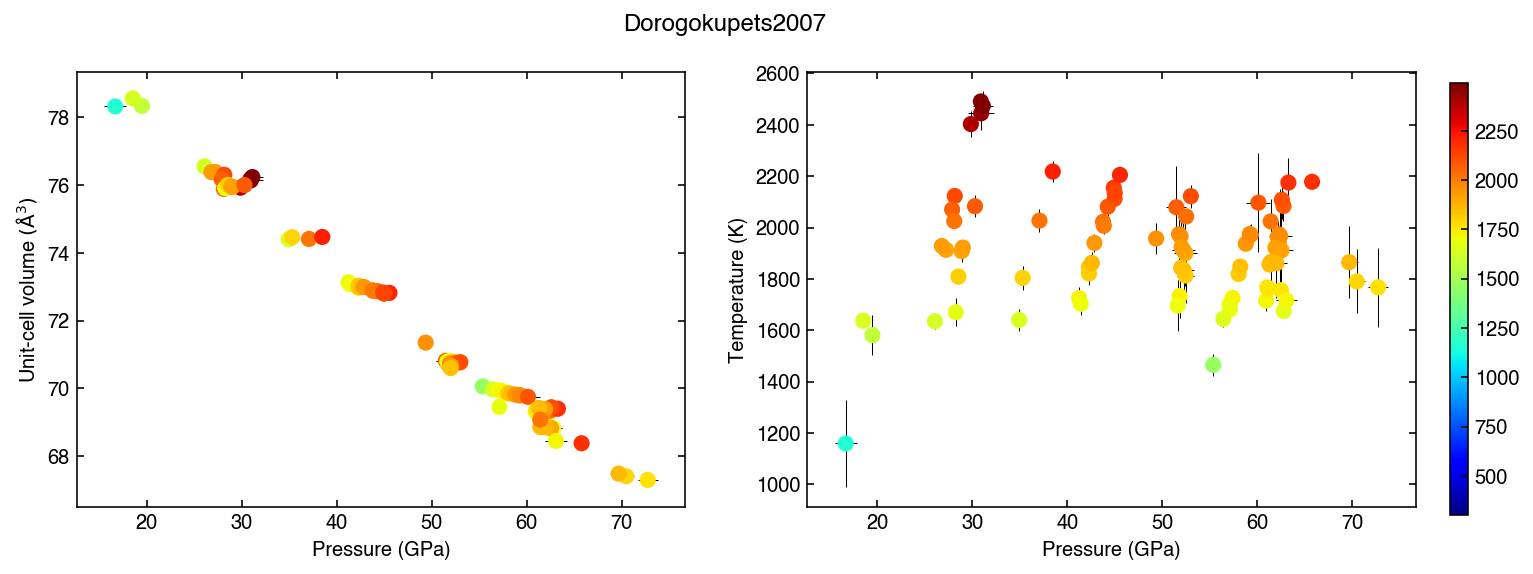

In [14]:
p = au_eos[key].cal_p(v_std, temp)
eos.plot.thermal_data({'p': p, 'v': v, 'temp': temp}, title=key)

# 4. Data fitting with constq equation (3C)

The cell below shows fitting using constant q assumptions for the thermal part of eos.

Normally weight for each data point can be calculated from $\sigma(P)$.  In this case, using `uncertainties`, we can easily propagate the temperature and volume uncertainties to get the value.

Calculate pressure

In [15]:
p = au_eos[key].cal_p(v_std, temp)

Add prefix to the parameters. This is important to distinguish thermal and static parameters

In [16]:
eos_st = st_model[key](prefix='st_') 
eos_th = eos.ConstqModel(n, z, prefix='th_')

Define initial values for parameters

In [17]:
params = eos_st.make_params(v0=v0, k0=k0[key], k0p=k0p[key])
params += eos_th.make_params(v0=v0, gamma0=gamma0, q=q, theta0=theta0)

Construct PVT eos.  Here we take advantage of lmfit to combine any formula of static and thermal eos's

In [18]:
pvteos = eos_st + eos_th

Fix static parameters and some other well known parameters

In [19]:
params['th_v0'].vary=False
params['th_gamma0'].vary=False
params['th_theta0'].vary=False
params['st_v0'].vary=False
params['st_k0'].vary=False
params['st_k0p'].vary=False

Calculate weights.  Setting it None results in unweighted fitting

In [20]:
weights = 1./unp.std_devs(p) #None

Conduct fitting.

In [21]:
fit_result = pvteos.fit(unp.nominal_values(p), params, v=unp.nominal_values(v), 
                               temp=unp.nominal_values(temp), weights=weights)

/Users/DanShim/anaconda/lib/python3.6/site-packages/lmfit/model.py:821: UserWarning: The keyword argument temp does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


Output the fitting results

/Users/DanShim/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


********Dorogokupets2007
[[Model]]
    (Model(vinet_p, prefix='st_') + Model(constq_pth, prefix='th_', n='2.0', z='4.0'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 83
    # variables        = 1
    chi-square         = 632.781052
    reduced chi-square = 7.71684210
    Akaike info crit   = 170.596561
    Bayesian info crit = 173.015401
[[Variables]]
    st_v0:      82.8042 (fixed)
    st_k0:      243 (fixed)
    st_k0p:     2.68 (fixed)
    th_v0:      82.8042 (fixed)
    th_gamma0:  1.06 (fixed)
    th_q:       0.77852420 +/- 0.13612096 (17.48%) (init = 1)
    th_theta0:  1200 (fixed)



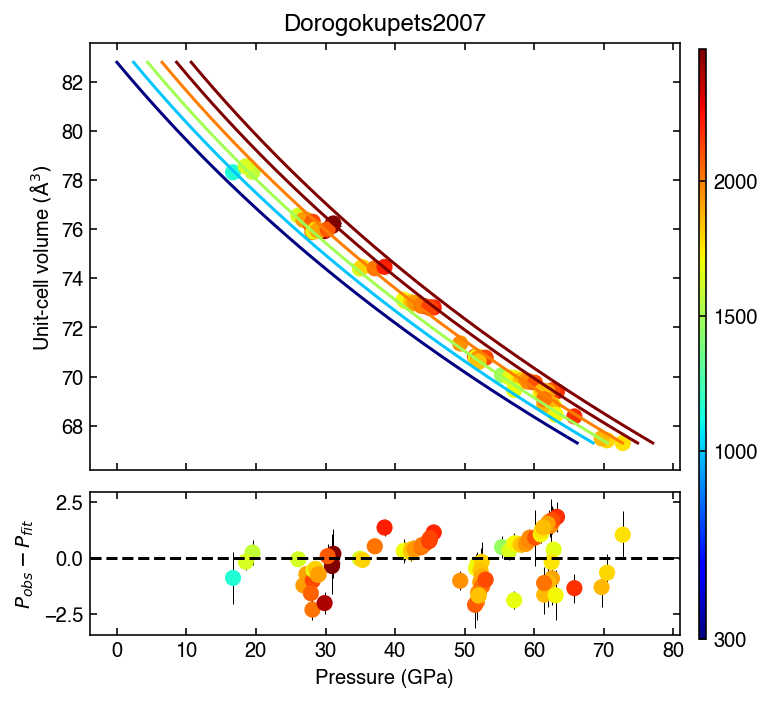

In [22]:
print('********'+key)
print(fit_result.fit_report())
# plot fitting results
eos.plot.thermal_fit_result(fit_result, p_err=unp.std_devs(p), v_err=unp.std_devs(v), title=key)

The warning message above is because the static EOS does not need temperature.  `lmfit` generates warning if an assigned independent variable is not used in fitting for any components.